# Data tidak seimbang dan fine-tuning

In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import tensorflow
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_benih = '/content/drive/My Drive/Penelitian/Dataset/'

In [ ]:
kelas = ['haploid', 'diploid']
kelas

['haploid', 'diploid']

In [ ]:
def get_data(data_dir):
    size = (224,224)
    label = 0
    x = []
    y = []
    for folder in kelas:
        print("Loading {}".format(data_dir+folder))
        for pic in tqdm(glob.glob(data_dir + folder + '/*')):
            im = cv2.imread(pic)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (size))
            x.append(im)
            y.append(label)
        label+=1
    x = np.array(x, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    return x,y

In [ ]:
x_train, y_train = get_data(path_benih + 'train/')
x_test, y_test = get_data(path_benih + 'test/')

Loading /content/drive/My Drive/Penelitian/Dataset/train/haploid


100%|██████████| 984/984 [00:16<00:00, 60.36it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/train/diploid


100%|██████████| 1416/1416 [00:22<00:00, 61.74it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/test/haploid


100%|██████████| 246/246 [00:03<00:00, 76.71it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/test/diploid


100%|██████████| 354/354 [00:04<00:00, 75.75it/s] 


In [ ]:
x_train/=255.
x_test/=255.

In [ ]:
len(x_train)+len(x_test)

3000

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [ ]:
# Import Best Model dari Ujicoba_1
best_dir = '/content/drive/My Drive/Penelitian/save_models/percobaan_1/'
model = load_model(best_dir+"model_4")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def print_layer_trainable(models):
  for layer in models.layers:
    print('{}:\t{}'.format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable(model)

True:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool
True:	flatten
True:	dense
True:	dropout
True:	dense_1
True:	dropout_1
True:	dense_2


In [ ]:
model.trainable = True
print("Layer pada model: {}".format(len(model.layers)))

Layer pada model: 28


In [ ]:
fine_tune_at = 14
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
print_layer_trainable(model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool
True:	flatten
True:	dense
True:	dropout
True:	dense_1
True:	dropout_1
True:	dense_2


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def get_model_name(k):
  return 'model_'+str(k)

In [ ]:
akurasi_val_data=[]
AUC=[]
CV=[]
waktu=[]

LOSS=[]
VAL_LOSS=[]
ACCURACY=[]
VAL_ACCURACY=[]

fold_var = 1
max_epoch = 64
mini_batch = 32
lr = 0.0001

save_dir = '/content/drive/My Drive/Penelitian/save_models/percobaan_2/'

In [ ]:
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(x_train, y_train):
  print("---------- FOLD KE- {} ----------".format(fold_var))
  x_training, y_training = x_train[train_index], y_train[train_index]
  x_validasi, y_validasi = x_train[val_index], y_train[val_index]

  y_training = to_categorical(y_training)   
  y_validasi = to_categorical(y_validasi)
  
  model.compile(optimizer=Adam(learning_rate=lr), 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # min_delta (perubahan minimal), patience (jumlah epoch tanpa perbaikan)
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var),
                               monitor='val_accuracy', verbose=1,
                               save_best_only=True, mode='max')
  callback_list = [early_stop, checkpoint]

  start = datetime.datetime.now()
  hist = model.fit(x_training, y_training, 
                   epochs=max_epoch,
                   batch_size=mini_batch,
                   callbacks=callback_list,
                   validation_data = (x_validasi, y_validasi))
  end = datetime.datetime.now()
  jam = end - start

  model = load_model(save_dir+"model_"+str(fold_var))

  predict = model.predict(x_validasi)
  predict = np.argmax(predict, axis=1)
  labels = np.argmax(y_validasi, axis=1)
  print(classification_report(labels, predict, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))
  print('Waktu Pelatihan Data : ', jam, '\n\n')
  acc = accuracy_score(labels, predict)
  auc = roc_auc_score(labels, predict)

  waktu.append(jam)
  akurasi_val_data.append(acc)
  AUC.append(auc)
  LOSS.append(hist.history['loss'])
  ACCURACY.append(hist.history['accuracy'])
  VAL_LOSS.append(hist.history['val_loss'])
  VAL_ACCURACY.append(hist.history['val_accuracy'])
  CV.append('CV-'+str(fold_var))

  clear_session()
  fold_var+=1

---------- FOLD KE- 1 ----------
Epoch 1/64
60/60 [==============================] - ETA: 0s - loss: 0.9105 - accuracy: 0.5672
Epoch 1: val_accuracy improved from -inf to 0.59167, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_1


60/60 [==============================] - 37s 415ms/step - loss: 0.9105 - accuracy: 0.5672 - val_loss: 0.6741 - val_accuracy: 0.5917
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.5943
Epoch 2: val_accuracy improved from 0.59167 to 0.68542, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_1


60/60 [==============================] - 24s 401ms/step - loss: 0.6624 - accuracy: 0.5943 - val_loss: 0.5874 - val_accuracy: 0.6854
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.6115
Epoch 3: val_accuracy did not improve from 0.68542
60/60 [==============================] - 17s 285ms/step - loss: 0.6383 - accuracy: 0.6115 - val_loss: 0.6681 - val_accuracy: 0.5917
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.6198
Epoch 4: val_accuracy did not improve from 0.68542
60/60 [==============================] - 17s 287ms/step - loss: 0.6506 - accuracy: 0.6198 - val_loss: 0.5899 - val_accuracy: 0.6417
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.7135
Epoch 5: val_accuracy improved from 0.68542 to 0.79583, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_1


60/60 [==============================] - 25s 415ms/step - loss: 0.5444 - accuracy: 0.7135 - val_loss: 0.4419 - val_accuracy: 0.7958
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.4031 - accuracy: 0.8104
Epoch 6: val_accuracy improved from 0.79583 to 0.82917, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_1


60/60 [==============================] - 24s 397ms/step - loss: 0.4031 - accuracy: 0.8104 - val_loss: 0.3780 - val_accuracy: 0.8292
Epoch 7/64
60/60 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8818
Epoch 7: val_accuracy did not improve from 0.82917
60/60 [==============================] - 17s 290ms/step - loss: 0.3027 - accuracy: 0.8818 - val_loss: 0.4424 - val_accuracy: 0.7896
Epoch 8/64
60/60 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8849
Epoch 8: val_accuracy improved from 0.82917 to 0.88125, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_1


60/60 [==============================] - 25s 416ms/step - loss: 0.2720 - accuracy: 0.8849 - val_loss: 0.2853 - val_accuracy: 0.8813
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.8922
Epoch 9: val_accuracy did not improve from 0.88125
60/60 [==============================] - 20s 330ms/step - loss: 0.2732 - accuracy: 0.8922 - val_loss: 0.2844 - val_accuracy: 0.8708
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9062
Epoch 10: val_accuracy did not improve from 0.88125
60/60 [==============================] - 17s 291ms/step - loss: 0.2277 - accuracy: 0.9062 - val_loss: 0.3289 - val_accuracy: 0.8604
Epoch 11/64
60/60 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9234
Epoch 11: val_accuracy improved from 0.88125 to 0.89792, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_1


60/60 [==============================] - 24s 411ms/step - loss: 0.1907 - accuracy: 0.9234 - val_loss: 0.2438 - val_accuracy: 0.8979
Epoch 12/64
60/60 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9401
Epoch 12: val_accuracy did not improve from 0.89792
60/60 [==============================] - 17s 289ms/step - loss: 0.1592 - accuracy: 0.9401 - val_loss: 0.2582 - val_accuracy: 0.8938
Epoch 13/64
60/60 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9385
Epoch 13: val_accuracy did not improve from 0.89792
60/60 [==============================] - 20s 332ms/step - loss: 0.1648 - accuracy: 0.9385 - val_loss: 0.2485 - val_accuracy: 0.8979
Epoch 14/64
60/60 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9552
Epoch 14: val_accuracy did not improve from 0.89792
60/60 [==============================] - 17s 289ms/step - loss: 0.1337 - accuracy: 0.9552 - val_loss: 0.4198 - val_accuracy: 0.8562
Epoch 15/64
60/60 [============

60/60 [==============================] - 25s 419ms/step - loss: 0.1178 - accuracy: 0.9542 - val_loss: 0.3407 - val_accuracy: 0.9062
Epoch 17/64
60/60 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9443
Epoch 17: val_accuracy did not improve from 0.90625
60/60 [==============================] - 17s 290ms/step - loss: 0.1339 - accuracy: 0.9443 - val_loss: 0.3292 - val_accuracy: 0.8875
Epoch 18/64
60/60 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9573
Epoch 18: val_accuracy did not improve from 0.90625
60/60 [==============================] - 20s 333ms/step - loss: 0.1128 - accuracy: 0.9573 - val_loss: 0.3991 - val_accuracy: 0.8750
Epoch 18: early stopping
15/15 [==============================] - 3s 181ms/step
                   precision    recall  f1-score   support

Haploid (Class 0)       0.90      0.87      0.88       196
Diploid (Class 1)       0.91      0.93      0.92       284

         accuracy                           0.91   

60/60 [==============================] - 26s 420ms/step - loss: 0.1876 - accuracy: 0.9281 - val_loss: 0.1440 - val_accuracy: 0.9438
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9490
Epoch 2: val_accuracy improved from 0.94375 to 0.95000, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_2


60/60 [==============================] - 25s 412ms/step - loss: 0.1393 - accuracy: 0.9490 - val_loss: 0.1460 - val_accuracy: 0.9500
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9490
Epoch 3: val_accuracy did not improve from 0.95000
60/60 [==============================] - 20s 333ms/step - loss: 0.1253 - accuracy: 0.9490 - val_loss: 0.1213 - val_accuracy: 0.9458
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9521
Epoch 4: val_accuracy improved from 0.95000 to 0.95208, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_2


60/60 [==============================] - 22s 373ms/step - loss: 0.1254 - accuracy: 0.9521 - val_loss: 0.1152 - val_accuracy: 0.9521
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9703
Epoch 5: val_accuracy did not improve from 0.95208
60/60 [==============================] - 17s 290ms/step - loss: 0.0936 - accuracy: 0.9703 - val_loss: 0.1485 - val_accuracy: 0.9438
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9557
Epoch 6: val_accuracy did not improve from 0.95208
60/60 [==============================] - 20s 331ms/step - loss: 0.1174 - accuracy: 0.9557 - val_loss: 0.1212 - val_accuracy: 0.9521
Epoch 7/64
60/60 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9750
Epoch 7: val_accuracy did not improve from 0.95208
60/60 [==============================] - 17s 289ms/step - loss: 0.0688 - accuracy: 0.9750 - val_loss: 0.1544 - val_accuracy: 0.9354
Epoch 8/64
60/60 [===================

60/60 [==============================] - 25s 412ms/step - loss: 0.0577 - accuracy: 0.9771 - val_loss: 0.1252 - val_accuracy: 0.9667
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9781
Epoch 9: val_accuracy did not improve from 0.96667
60/60 [==============================] - 17s 291ms/step - loss: 0.0637 - accuracy: 0.9781 - val_loss: 0.2542 - val_accuracy: 0.9333
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9661
Epoch 10: val_accuracy did not improve from 0.96667
60/60 [==============================] - 18s 293ms/step - loss: 0.0989 - accuracy: 0.9661 - val_loss: 0.1675 - val_accuracy: 0.9458
Epoch 11/64
60/60 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9823
Epoch 11: val_accuracy did not improve from 0.96667
60/60 [==============================] - 20s 331ms/step - loss: 0.0495 - accuracy: 0.9823 - val_loss: 0.1874 - val_accuracy: 0.9458
Epoch 11: early stopping
15/15 [=

60/60 [==============================] - 23s 377ms/step - loss: 0.1072 - accuracy: 0.9620 - val_loss: 0.0558 - val_accuracy: 0.9792
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9625
Epoch 2: val_accuracy improved from 0.97917 to 0.98125, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_3


60/60 [==============================] - 23s 378ms/step - loss: 0.0867 - accuracy: 0.9625 - val_loss: 0.0523 - val_accuracy: 0.9812
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9786
Epoch 3: val_accuracy improved from 0.98125 to 0.98333, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_3


60/60 [==============================] - 22s 376ms/step - loss: 0.0575 - accuracy: 0.9786 - val_loss: 0.0556 - val_accuracy: 0.9833
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9797
Epoch 4: val_accuracy did not improve from 0.98333
60/60 [==============================] - 20s 330ms/step - loss: 0.0586 - accuracy: 0.9797 - val_loss: 0.0699 - val_accuracy: 0.9729
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9740
Epoch 5: val_accuracy did not improve from 0.98333
60/60 [==============================] - 20s 330ms/step - loss: 0.0758 - accuracy: 0.9740 - val_loss: 0.0958 - val_accuracy: 0.9583
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9719
Epoch 6: val_accuracy did not improve from 0.98333
60/60 [==============================] - 20s 331ms/step - loss: 0.0712 - accuracy: 0.9719 - val_loss: 0.1023 - val_accuracy: 0.9479
Epoch 7/64
60/60 [===================

60/60 [==============================] - 24s 384ms/step - loss: 0.0755 - accuracy: 0.9734 - val_loss: 0.0508 - val_accuracy: 0.9833
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9771
Epoch 2: val_accuracy did not improve from 0.98333
60/60 [==============================] - 20s 332ms/step - loss: 0.0601 - accuracy: 0.9771 - val_loss: 0.0949 - val_accuracy: 0.9667
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9875
Epoch 3: val_accuracy improved from 0.98333 to 0.98750, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_4


60/60 [==============================] - 25s 416ms/step - loss: 0.0328 - accuracy: 0.9875 - val_loss: 0.0205 - val_accuracy: 0.9875
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9802
Epoch 4: val_accuracy did not improve from 0.98750
60/60 [==============================] - 20s 331ms/step - loss: 0.0532 - accuracy: 0.9802 - val_loss: 0.1245 - val_accuracy: 0.9521
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9792
Epoch 5: val_accuracy did not improve from 0.98750
60/60 [==============================] - 17s 291ms/step - loss: 0.0559 - accuracy: 0.9792 - val_loss: 0.0862 - val_accuracy: 0.9688
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9849
Epoch 6: val_accuracy did not improve from 0.98750
60/60 [==============================] - 20s 332ms/step - loss: 0.0411 - accuracy: 0.9849 - val_loss: 0.0857 - val_accuracy: 0.9708
Epoch 7/64
60/60 [===================

60/60 [==============================] - 27s 427ms/step - loss: 0.0566 - accuracy: 0.9807 - val_loss: 0.0486 - val_accuracy: 0.9875
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9750
Epoch 2: val_accuracy improved from 0.98750 to 0.98958, saving model to /content/drive/My Drive/Penelitian/save_models/percobaan_2/model_5


60/60 [==============================] - 23s 383ms/step - loss: 0.0696 - accuracy: 0.9750 - val_loss: 0.0299 - val_accuracy: 0.9896
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9932
Epoch 3: val_accuracy did not improve from 0.98958
60/60 [==============================] - 20s 332ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.0627 - val_accuracy: 0.9812
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9802
Epoch 4: val_accuracy did not improve from 0.98958
60/60 [==============================] - 20s 330ms/step - loss: 0.0627 - accuracy: 0.9802 - val_loss: 0.0796 - val_accuracy: 0.9625
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9859
Epoch 5: val_accuracy did not improve from 0.98958
60/60 [==============================] - 20s 331ms/step - loss: 0.0380 - accuracy: 0.9859 - val_loss: 0.0412 - val_accuracy: 0.9875
Epoch 6/64
60/60 [===================

60/60 [==============================] - 25s 414ms/step - loss: 0.0135 - accuracy: 0.9964 - val_loss: 0.0217 - val_accuracy: 0.9917
Epoch 8/64
60/60 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9943
Epoch 8: val_accuracy did not improve from 0.99167
60/60 [==============================] - 20s 331ms/step - loss: 0.0210 - accuracy: 0.9943 - val_loss: 0.0748 - val_accuracy: 0.9708
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9844
Epoch 9: val_accuracy did not improve from 0.99167
60/60 [==============================] - 20s 333ms/step - loss: 0.0401 - accuracy: 0.9844 - val_loss: 0.0610 - val_accuracy: 0.9771
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9880
Epoch 10: val_accuracy did not improve from 0.99167
60/60 [==============================] - 20s 330ms/step - loss: 0.0361 - accuracy: 0.9880 - val_loss: 0.0543 - val_accuracy: 0.9812
Epoch 11/64
60/60 [================

In [ ]:
print(akurasi_val_data)
print(AUC)
print(CV)
print(waktu)

print(LOSS)
print(VAL_LOSS)
print(ACCURACY)
print(VAL_ACCURACY)

[0.90625, 0.9666666666666667, 0.9833333333333333, 0.9875, 0.9916666666666667]
[0.9002227651624028, 0.9694175889221718, 0.9850944377679325, 0.9886280066725259, 0.9929328621908127]
['CV-1', 'CV-2', 'CV-3', 'CV-4', 'CV-5']
[datetime.timedelta(seconds=385, microseconds=124016), datetime.timedelta(seconds=227, microseconds=439797), datetime.timedelta(seconds=183, microseconds=201066), datetime.timedelta(seconds=205, microseconds=821326), datetime.timedelta(seconds=285, microseconds=941894)]
[[0.9105017185211182, 0.6623889207839966, 0.6383435130119324, 0.6505926847457886, 0.544442355632782, 0.40314537286758423, 0.3026668131351471, 0.2719614803791046, 0.2732120156288147, 0.22770076990127563, 0.19067390263080597, 0.15919868648052216, 0.16483473777770996, 0.1336885541677475, 0.12686721980571747, 0.11781131476163864, 0.1338508129119873, 0.11279132217168808], [0.18763452768325806, 0.13934941589832306, 0.12529867887496948, 0.12535522878170013, 0.09357793629169464, 0.11742504686117172, 0.0687781721

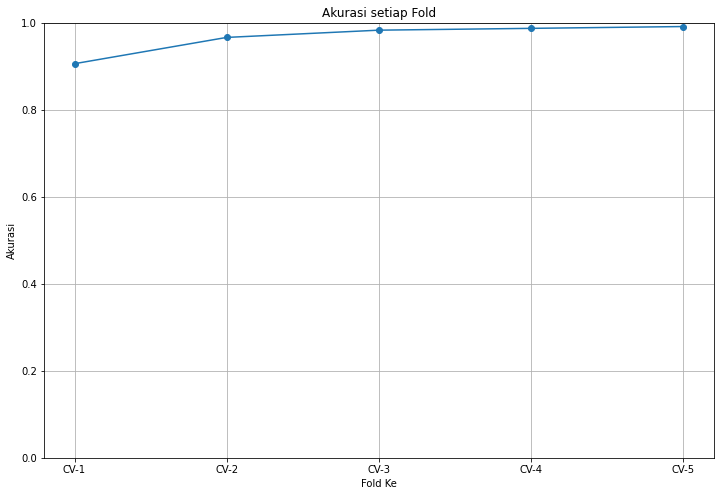

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(CV, akurasi_val_data, marker='o')
plt.title('Akurasi setiap Fold')
plt.xlabel('Fold Ke')
plt.ylabel('Akurasi')
plt.ylim((0., 1))
plt.grid()
plt.show()

In [ ]:
def visualisasi_fit(judul, n_train, n_val):
  fig, ax = plt.subplots(3,2,constrained_layout=True, figsize=(15,10))
  index=0
  for i in range(3):
    for j in range(2):
      if j==0:
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
      else:
        if index==5:
          break
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
      ax[i,j].grid()
      ax[i,j].set_ylim((0., 1))
      ax[i,j].legend()
      index+=1

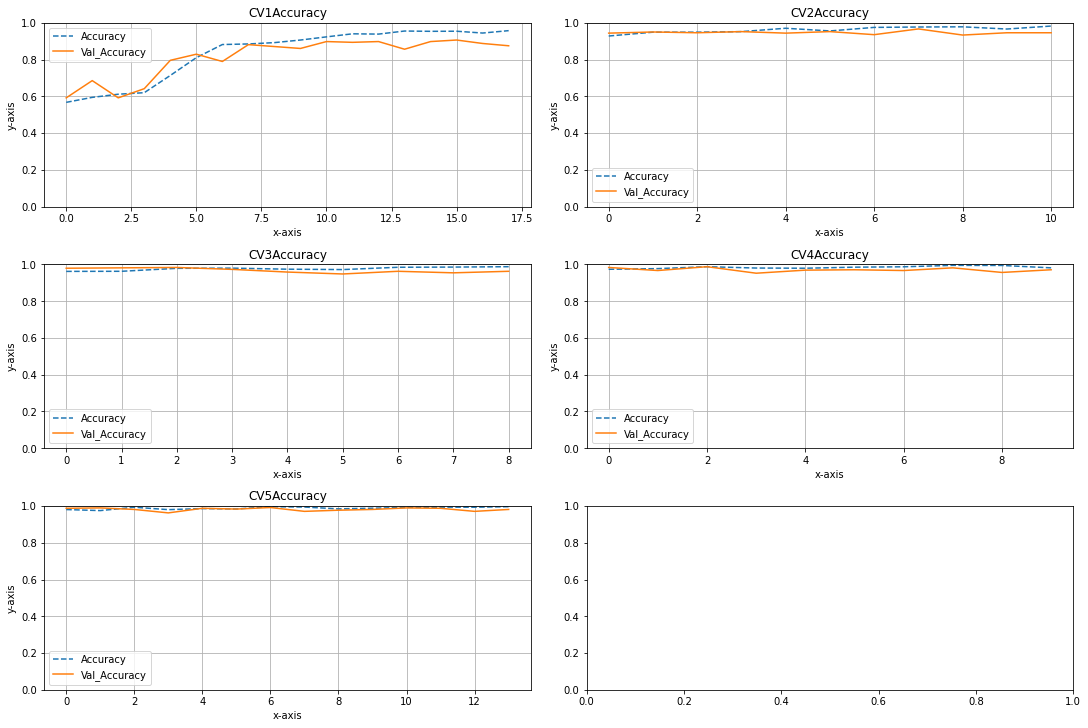

In [ ]:
vis_akurasi = visualisasi_fit('Accuracy', ACCURACY, VAL_ACCURACY)
vis_akurasi

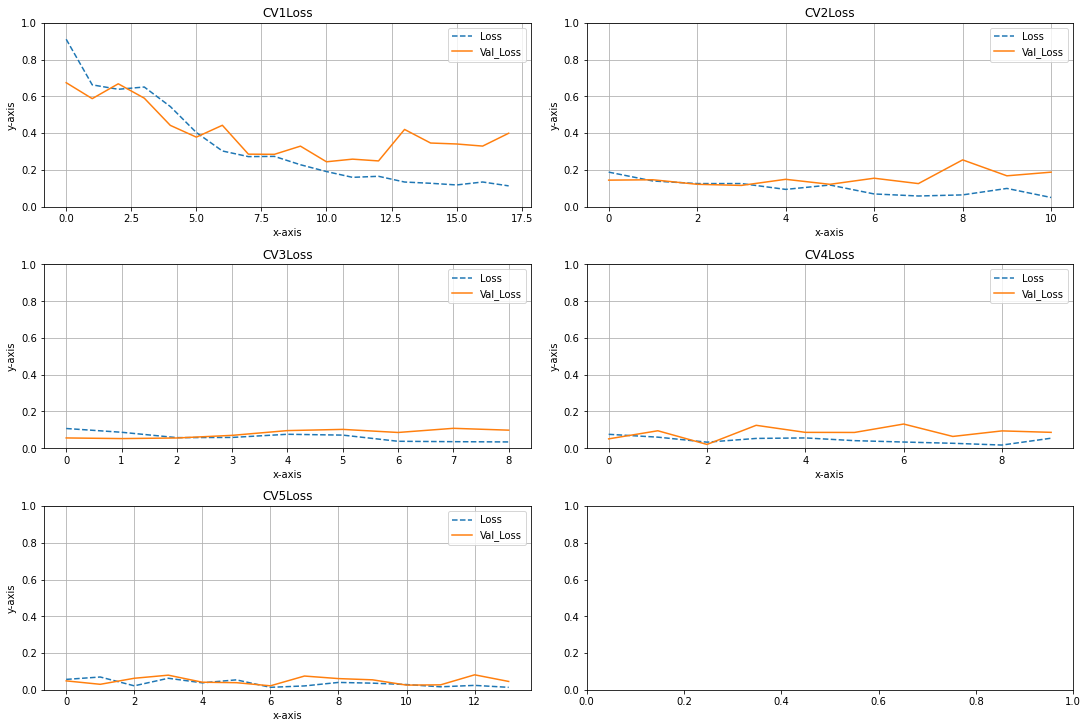

In [ ]:
vis_loss = visualisasi_fit('Loss', LOSS, VAL_LOSS)
vis_loss

In [ ]:
terbaik=[]
for i in range(5):
  nilai = (akurasi_val_data[i]+AUC[i])/2
  terbaik.append(nilai)

In [ ]:
terbaik

[0.9032363825812014,
 0.9680421277944192,
 0.9842138855506328,
 0.988064003336263,
 0.9922997644287397]

In [ ]:
s=0
baik=1
for i, v in enumerate(terbaik):
  if v>s:
    s=v
    baik=i+1
  else:
    continue
print(baik, s)

5 0.9922997644287397


In [ ]:
model = load_model(save_dir+"model_"+str(baik))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

19/19 [==============================] - 6s 307ms/step


In [ ]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
f1score_test = f1_score(y_test, y_pred)

In [ ]:
print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.9516666666666667
Prec Test :  0.9310344827586207
Rec Test :  0.9915254237288136
F1-Score Test :  0.9603283173734611


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))

                   precision    recall  f1-score   support

Haploid (Class 0)       0.99      0.89      0.94       246
Diploid (Class 1)       0.93      0.99      0.96       354

         accuracy                           0.95       600
        macro avg       0.96      0.94      0.95       600
     weighted avg       0.95      0.95      0.95       600



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[220,  26],
       [  3, 351]])

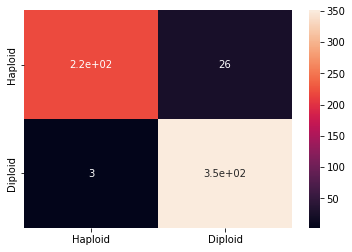

In [ ]:
sns.heatmap(cm, annot=True, xticklabels=['Haploid', 'Diploid'], yticklabels=['Haploid', 'Diploid'])

In [ ]:
def plot_roc_curve(true_y, y_prob): 
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Model AUC score : 0.9429171834091221


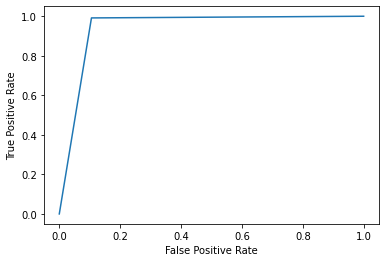

In [ ]:
plot_roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('Model AUC score : {}'.format(auc))